***
*Course:* [Math 535](http://www.math.wisc.edu/~roch/mmids/) - Mathematical Methods in Data Science (MMiDS)  
*Author:* [Sebastien Roch](http://www.math.wisc.edu/~roch/), Department of Mathematics, University of Wisconsin-Madison  
***

# <span style="background-color:dodgerblue; color:white; padding:2px 6px">APPLICATIONS</span> 
# Deep neural networks


*Updated:* April 16, 2020 

In [1]:
#Julia version: 1.3.1
ENV["JULIA_CUDA_SILENT"] = true # silences warning about GPUs

using CSV, DataFrames, GLM, Statistics, Images, QuartzImageIO
using Flux, Flux.Data.MNIST, Flux.Data.FashionMNIST
using Flux: mse, train!, Data.DataLoader, throttle
using Flux: onehot, onehotbatch, onecold, crossentropy
using IterTools: ncycle

## 1 Background

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Today&#39;s paper shows that it is possible to implement John Von Neumann&#39;s claim: &quot;With 4 parameters I can ﬁt an elephant, and with 5 I can make him wiggle his trunk&quot;<br><br>Paper here: <a href="https://t.co/SvVrLuRFNy">https://t.co/SvVrLuRFNy</a> <a href="https://t.co/VG37439vE7">pic.twitter.com/VG37439vE7</a></p>&mdash; Fermat&#39;s Library (@fermatslibrary) <a href="https://twitter.com/fermatslibrary/status/965971333422120962?ref_src=twsrc%5Etfw">February 20, 2018</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

In this optional notebook, we illustrate the use of automatic differentiation on multiclass classification with deep neural networks. We will not expand on the concepts required here. Review [[Wri](http://www.optimization-online.org/DB_FILE/2016/12/5748.pdf), Section 2.11] first, and then see the following references for background:

1. *Convolutional neural networks:* See [[Bis](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf), Sections 5.1-2, 5.3.1-2, 5.5.6-7] and this [module](http://cs231n.github.io/convolutional-networks/) from Stanford's [CS231n](http://cs231n.github.io/).

2. *Automatic differentiation:* See this [Wikipedia article](https://en.wikipedia.org/wiki/Automatic_differentiation#The_chain_rule,_forward_and_reverse_accumulation).

3. *Flux.jl:* See the [documentation](https://fluxml.ai/Flux.jl/stable/models/basics/#Model-Building-Basics-1) for the [Flux.jl](https://fluxml.ai) package.

We have already used automatic differentiation and Flux.jl in previous notebooks. We introduce more advanced features here.

## 2 Linear regression

We begin by using [Flux.jl](https://fluxml.ai) on one problem we have encountered previously, linear regression.

### 2.1 Flux

The `Dense` function constructs an affine map from `in` predictor variables to `out` response variables. It is defined a special way that its parameters, the matrix `W` and the intercept vector `b`, can be accessed by `m.W` and `m.b` if `m` is the name given to the function.  

We will also use some other utility functions. The function `mse` computes the mean squared error (MSE). It will be our loss function in this section. The functions `DataLoader` and `ncycle` allow us to construct mini-batches in a straightforward way. Finally `thottle` is used to print progress messages.

The help rubric of each of these is below.

In [2]:
?Dense

search: Dense DenseArray DenseVector DenseMatrix DenseVecOrMat DenseConvDims



```
Dense(in::Integer, out::Integer, σ = identity)
```

Creates a traditional `Dense` layer with parameters `W` and `b`.

```
y = σ.(W * x .+ b)
```

The input `x` must be a vector of length `in`, or a batch of vectors represented as an `in × N` matrix. The out `y` will be a vector or batch of length `out`.

```julia
julia> d = Dense(5, 2)
Dense(5, 2)

julia> d(rand(5))
Tracked 2-element Array{Float64,1}:
  0.00257447
  -0.00449443
```


In [3]:
?mse

search: mse rmse imstretch imresize SumSquaredDifference CompositeException



```
mse(ŷ, y)
```

Return the mean squared error `sum((ŷ .- y).^2) / length(y)`. 


In [4]:
?DataLoader

search:



```
DataLoader(data...; batchsize=1, shuffle=false, partial=true)
```

An object that iterates over mini-batches of `data`, each mini-batch containing `batchsize` observations (except possibly the last one). 

Takes as input one or more data tensors, e.g. X in unsupervised learning, X and Y in  supervised learning. The last dimension in each tensor is considered to be the observation dimension. 

If `shuffle=true`, shuffles the observations each time iterations are re-started. If `partial=false`, drops the last mini-batch if it is smaller than the batchsize.

The original data is preserved as a tuple in the `data` field of the DataLoader. 

Example usage:

```
Xtrain = rand(10, 100)
train_loader = DataLoader(Xtrain, batchsize=2) 
# iterate over 50 mini-batches of size 2
for x in train_loader: 
    @assert size(x) == (10, 2)
    ...
end

train_loader.data   # original dataset

Xtrain = rand(10, 100)
Ytrain = rand(100)
train_loader = DataLoader(Xtrain, Ytrain, batchsize=2, shuffle=true) 
for epoch in 1:100
    for (x, y) in train_loader: 
        @assert size(x) == (10, 2)
        @assert size(y) == (2,)
        ...
    end
end

# train for 10 epochs
using IterTools: ncycle 
Flux.train!(loss, ps, ncycle(train_loader, 10), opt)
```


In [5]:
?ncycle

search:



```
ncycle(iter, n)
```

Cycle through `iter` `n` times.

```jldoctest
julia> for i in ncycle(1:3, 2)
           @show i
       end
i = 1
i = 2
i = 3
i = 1
i = 2
i = 3
```


In [6]:
?throttle

search:



Returns a function that when invoked, will only be triggered at most once during `timeout` seconds. Normally, the throttled function will run as much as it can, without ever going more than once per `wait` duration; but if you'd like to disable the execution on the leading edge, pass `leading=false`. To enable execution on the trailing edge, ditto.


### 2.2 `Advertising` dataset and least-squares solution

We return to the `Advertising` dataset.

In [7]:
df = DataFrame(CSV.File("./advertising.csv"))
first(df,5)

,Column1,TV,radio,newspaper,sales
,Int64,Float64,Float64,Float64,Float64
1,1,230.1,37.8,69.2,22.1
2,2,44.5,39.3,45.1,10.4
3,3,17.2,45.9,69.3,9.3
4,4,151.5,41.3,58.5,18.5
5,5,180.8,10.8,58.4,12.9


In [8]:
n = nrow(df)

200

We first compute the solution using the least-squares approach we detailed previously.

In [9]:
X = reduce(hcat, [df[:,:TV], df[:,:radio], df[:,:newspaper]])
Xaug = hcat(ones(n), X)
y = df[:,:sales];

In [10]:
@time q = Xaug\y

  1.206607 seconds (3.21 M allocations: 154.619 MiB, 5.52% gc time)


4-element Array{Float64,1}:
  2.938889369459415    
  0.04576464545539759  
  0.18853001691820445  
 -0.0010374930424763011

The MSE is:

In [11]:
mean((Xaug*q .- y).^2)

2.7841263145109356

### 2.3 Solving the problem using Flux

We use `DataLoader` to set up the data for Flux. Note that it takes the transpose of what we have been using, that is, the columns of the data matrix correspond to the samples. Here we take min-batches of size `batchsize=20` and the option `shuffle=true` indicates that we apply a random permutation of the samples on every pass through the data. 

In [12]:
Xtrain = X'
ytrain = reshape(y, (1,length(y)))
loader = DataLoader(Xtrain, ytrain; batchsize=20, shuffle=true);

For example, the first component of the first item is the features for the first 20 samples (after random permutation).

In [13]:
first(loader)[1]

3×20 Array{Float64,2}:
 50.0  188.4  198.9  70.6  25.6  75.5  …  39.5  76.4  280.7  38.2  48.3
 11.6   18.1   49.4  16.0  39.0  10.8     41.1   0.8   13.9   3.7  47.0
 18.4   25.6   60.0  40.8   9.3   6.0      5.8  14.8   37.0  13.8   8.5

Now we construct our model. It is simply an affine map from $\mathbb{R}^3$ to $\mathbb{R}$.

In [14]:
m = Dense(3, 1)

Dense(3, 1)

The loss function is the MSE.

In [15]:
loss(x,y) = mse(m(x),y) 

loss (generic function with 1 method)

Finally, the function [`train!`](https://fluxml.ai/Flux.jl/stable/training/training/#Flux.Optimise.train!) runs an optimization method of our choice on the loss function. The `!` in the function name indicates that it modifies the parameters we pass to it, in this case `m.W` and `m.b`. There are many [optimizers](https://fluxml.ai/Flux.jl/stable/training/optimisers/#Optimiser-Reference-1) available . Stochastic gradient descent can chosen with [Descent](https://fluxml.ai/Flux.jl/stable/training/optimisers/#Flux.Optimise.Descent) but it is slow. Insteadm we will use the popular [ADAM](https://fluxml.ai/Flux.jl/stable/training/optimisers/#Flux.Optimise.ADAM). See this [post](https://hackernoon.com/demystifying-different-variants-of-gradient-descent-optimization-algorithm-19ae9ba2e9bc) for a brief explanation of many common optimizers.

We also pass the parameters to `train!` using `params` and a callback function `evalcb()` that prints progress. 

Choosing the right number of passes (i.e. epochs) through the data requires some experimenting. Here $10^4$ suffices.

In [16]:
ps = params(m)
opt = ADAM()
evalcb =() -> @show(loss(Xtrain,ytrain));

In [17]:
@time train!(loss, ps, ncycle(loader, Int(1e4)), opt, cb = throttle(evalcb, 2))

loss(Xtrain, ytrain) = 8232.279045854151
loss(Xtrain, ytrain) = 2.8080499476318868
loss(Xtrain, ytrain) = 2.8222149375067676
loss(Xtrain, ytrain) = 2.784338307397086
loss(Xtrain, ytrain) = 2.7841753653448005
loss(Xtrain, ytrain) = 2.7904427669621223
loss(Xtrain, ytrain) = 2.7846128331698248
 21.511215 seconds (90.20 M allocations: 3.040 GiB, 4.00% gc time)


The final parameters and loss are:

In [18]:
m.b

1-element Array{Float32,1}:
 2.9353812

In [19]:
m.W

1×3 Array{Float32,2}:
 0.0455294  0.189447  -0.000817337

In [20]:
loss(Xtrain,ytrain)

2.7848454944144128

## 3 MNIST dataset

Next, we move on to a multicass classification problem. We will use the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset. Quoting [Wikipedia](https://en.wikipedia.org/wiki/MNIST_database):

> The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. The database is also widely used for training and testing in the field of machine learning. It was created by "re-mixing" the samples from NIST's original datasets. The creators felt that since NIST's training dataset was taken from American Census Bureau employees, while the testing dataset was taken from American high school students, it was not well-suited for machine learning experiments. Furthermore, the black and white images from NIST were normalized to fit into a 28x28 pixel bounding box and anti-aliased, which introduced grayscale levels. The MNIST database contains 60,000 training images and 10,000 testing images. Half of the training set and half of the test set were taken from NIST's training dataset, while the other half of the training set and the other half of the test set were taken from NIST's testing dataset.

Here is a sample of the images:

![MNIST sample images](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

([Source](https://commons.wikimedia.org/wiki/File:MnistExamples.png))

We first load the data and convert it to an appropriate matrix representation. The data can be accessed with `Flux.Data.MNIST`.

In [21]:
imgs = MNIST.images()
labels = MNIST.labels()
length(imgs)

60000

For example, the first image and its label are:

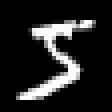

In [22]:
imgs[1]

In [23]:
labels[1]

5

We first transform the images into vectors using `reshape`.

In [24]:
?reshape

search: reshape promote_shape



```
reshape(A, dims...) -> AbstractArray
reshape(A, dims) -> AbstractArray
```

Return an array with the same data as `A`, but with different dimension sizes or number of dimensions. The two arrays share the same underlying data, so that the result is mutable if and only if `A` is mutable, and setting elements of one alters the values of the other.

The new dimensions may be specified either as a list of arguments or as a shape tuple. At most one dimension may be specified with a `:`, in which case its length is computed such that its product with all the specified dimensions is equal to the length of the original array `A`. The total number of elements must not change.

# Examples

```jldoctest
julia> A = Vector(1:16)
16-element Array{Int64,1}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
 14
 15
 16

julia> reshape(A, (4, 4))
4×4 Array{Int64,2}:
 1  5   9  13
 2  6  10  14
 3  7  11  15
 4  8  12  16

julia> reshape(A, 2, :)
2×8 Array{Int64,2}:
 1  3  5  7   9  11  13  15
 2  4  6  8  10  12  14  16

julia> reshape(1:6, 2, 3)
2×3 reshape(::UnitRange{Int64}, 2, 3) with eltype Int64:
 1  3  5
 2  4  6
```


In [25]:
reshape(Float32.(imgs[1]),:)

784-element Array{Float32,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮  
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

Using a list comprehension and `reduce` with `hcat`, we do this for every image in the dataset.

In [26]:
Xtrain = reduce(hcat, [reshape(Float32.(imgs[i]),:) for i = 1:length(imgs)]);

We can get back the original images by using `reshape` again.

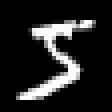

In [27]:
Gray.(reshape(Xtrain[:,1],(28,28)))

We also convert the labels into vectors. We use [one-hot encoding](https://fluxml.ai/Flux.jl/stable/data/onehot/), that is, we convert the label `0` to the standard basis $\mathbf{e}_1 \in \mathbb{R}^{10}$, the label `1` to $\mathbf{e}_2 \in \mathbb{R}^{10}$, and so on. The functions `onehot` and `onehotbatch` perform this transformation, while `onecold` undoes it.

In [28]:
?onehotbatch

search:



```
onehotbatch(ls, labels[, unk...])
```

Create an [`OneHotMatrix`](@ref) with a batch of labels based on possible `labels` set, returns the `onehot(unk, labels)` if given labels `ls` is not found in set `labels`.

## Examples

```jldoctest
julia> using Flux: onehotbatch

julia> onehotbatch([:b, :a, :b], [:a, :b, :c])
3×3 Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}:
 0  1  0
 1  0  1
 0  0  0
```


In [29]:
?onecold

search: SkipConnection ExponentialBackOff component_centroids



```
onecold(y[, labels = 1:length(y)])
```

Inverse operations of [`onehot`](@ref).

```jldoctest
julia> using Flux: onecold

julia> onecold([true, false, false], [:a, :b, :c])
:a

julia> onecold([0.3, 0.2, 0.5], [:a, :b, :c])
:c
```


For example, on the first label we get:

In [30]:
onehot(labels[1], 0:9)

10-element Flux.OneHotVector:
 0
 0
 0
 0
 0
 1
 0
 0
 0
 0

In [31]:
onecold(ans, 0:9)

5

We do this for all labels simultaneously.

In [32]:
ytrain = onehotbatch(labels, 0:9);

We will also use a test dataset provided in MNIST to assess the accuracy of our classifiers. We perform the same transformation.

In [33]:
test_imgs = MNIST.images(:test)
test_labels = MNIST.labels(:test)
length(test_labels)

10000

In [34]:
Xtest = reduce(hcat, 
    [reshape(Float32.(test_imgs[i]),:) for i = 1:length(test_imgs)])
ytest = onehotbatch(test_labels, 0:9);

## 4 Multinomial logistic regression

We first appeal to [multinomial logistic regression](https://en.wikipedia.org/wiki/Multinomial_logistic_regression) to learn a classifier for the MNIST data. See e.g. [[Bis](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf), Section 4.3.4] for background. For our purposes, it suffices to say that the model we are using takes the form of an affine map from $\mathbb{R}^{784}$ to $\mathbb{R}^{10}$ (where $784 = 28^2$ is the size of the images in vector form and $10$ is the dimension of the one-hot encoding of the labels) composed with the [softmax](https://en.wikipedia.org/wiki/Softmax_function) function which returns a probability distribution over the $10$ labels. The loss function is the [cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression).

In Flux, composition of functions can be achieved with `Chain`.

In [35]:
?Chain

search: Chain batched_adjoint channelview



```
Chain(layers...)
```

Chain multiple layers / functions together, so that they are called in sequence on a given input.

```julia
m = Chain(x -> x^2, x -> x+1)
m(5) == 26

m = Chain(Dense(10, 5), Dense(5, 2))
x = rand(10)
m(x) == m[2](m[1](x))
```

`Chain` also supports indexing and slicing, e.g. `m[2]` or `m[1:end-1]`. `m[1:3](x)` will calculate the output of the first three layers.


Hence our model is:

In [36]:
m = Chain(
    Dense(28^2, 10), 
    softmax
)

Chain(Dense(784, 10), softmax)

At initialization, the parameters are set randomly.

For example, one the first sample, we get the following probability distribution over labels:

In [37]:
m(Xtrain[:,1])

10-element Array{Float32,1}:
 0.16761522 
 0.07530861 
 0.048036132
 0.06496426 
 0.06505113 
 0.067898236
 0.064455174
 0.12192501 
 0.15675691 
 0.16798933 

We also define a function which computes the accuracy of the predictions.

In [38]:
accuracy(x, y) = mean(onecold(m(x), 0:9) .== onecold(y, 0:9));

With random initialization, the current accuracy on the test dataset is close to $10\%$, as one would expect from a purely random guess among $10$ choices.

In [39]:
accuracy(Xtest, ytest)

0.1071

We are now ready to make mini-batches and set the parameters of the optimizer. 

In [40]:
loader = DataLoader(Xtrain, ytrain; batchsize=128, shuffle=true);

In [41]:
loss(x, y) = crossentropy(m(x), y)
ps = params(m)
opt = ADAM()
evalcb = () -> @show(accuracy(Xtest,ytest));

We run ADAM for $10$ epochs. You can check for yourself that running it much longer does not lead to much improvement.

In [42]:
@time train!(loss, ps, ncycle(loader, Int(1e1)), opt, cb = throttle(evalcb, 2))

accuracy(Xtest, ytest) = 0.1236
accuracy(Xtest, ytest) = 0.9168
accuracy(Xtest, ytest) = 0.9225
  9.582298 seconds (29.52 M allocations: 5.115 GiB, 8.11% gc time)


The final accuracy is:

In [43]:
accuracy(Xtest, ytest)

0.9235

To make a prediction, we use `m(x)` which returns a probability distribution over the $10$ labels. The function `onecold` then returns the label with highest probability.

In [44]:
m(Xtest[:,1])

10-element Array{Float32,1}:
 9.711117e-6  
 2.5835983e-10
 1.8661505e-5 
 0.00591915   
 8.1335e-7    
 3.3519187e-5 
 1.5954298e-9 
 0.99363446   
 3.087511e-5  
 0.000352789  

In [45]:
onecold(ans, 0:9)

7

The true label in that case was:

In [46]:
onecold(ytest[:,1], 0:9)

7

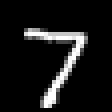

In [47]:
Gray.(test_imgs[1])

## 4 Going deeper

We now consider a more complex model by adding layers, that is, by composing with more affine functions. In between the affine maps, we introduce a nonlinear activation function, in this case [RELU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)).

In [48]:
m = Chain(
  Dense(28^2, 32, relu),
  Dense(32, 10),
  softmax
)

Chain(Dense(784, 32, relu), Dense(32, 10), softmax)

We then proceed as before.

In [49]:
loader = DataLoader(Xtrain, ytrain; batchsize=128, shuffle=true)
accuracy(x, y) = mean(onecold(m(x), 0:9) .== onecold(y, 0:9))
loss(x, y) = crossentropy(m(x), y)
ps = params(m)
opt = ADAM()
evalcb = () -> @show(accuracy(Xtest,ytest));

In [50]:
@time train!(loss, ps, ncycle(loader, Int(1e1)), opt, cb = throttle(evalcb, 2))

accuracy(Xtest, ytest) = 0.1441
accuracy(Xtest, ytest) = 0.9458
accuracy(Xtest, ytest) = 0.9569
accuracy(Xtest, ytest) = 0.9621
  8.793740 seconds (23.02 M allocations: 6.079 GiB, 7.22% gc time)


The final accuracy is better than that achieved with multiclass logistic regression:

In [51]:
accuracy(Xtest, ytest)

0.9654

As before, to make a prediction, we use `m(x)` and `onecold`.

In [52]:
onecold(m(Xtest[:,1]), 0:9)

7

In [53]:
onecold(ytest[:,1], 0:9)

7

## 5 Convolutional neural networks



Finally, we consider a class of neural networks tailored for image processing, [convolutional neural networks](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNN). From [Wikipedia](https://en.wikipedia.org/wiki/Convolutional_neural_network):

> In deep learning, a convolutional neural network (CNN, or ConvNet) is a class of deep neural networks, most commonly applied to analyzing visual imagery. They are also known as shift invariant or space invariant artificial neural networks (SIANN), based on their shared-weights architecture and translation invariance characteristics.

More background can be found in this excellent [module](http://cs231n.github.io/convolutional-networks/) from Stanford's [CS231n](http://cs231n.github.io/).

We will use CNNs on the MNIST dataset. What follows is based on Flux's [model zoo](https://github.com/FluxML/model-zoo/blob/master/vision/mnist/conv.jl). Our CNN will be a composition of [convolutional layers](http://cs231n.github.io/convolutional-networks/#conv) and [pooling layers](http://cs231n.github.io/convolutional-networks/#pool).

In [54]:
?Conv

search: Conv conv conv! convert ConvDims convexhull ConvTranspose ∇conv_data



```
Conv(size, in=>out)
Conv(size, in=>out, relu)
```

Standard convolutional layer. `size` should be a tuple like `(2, 2)`. `in` and `out` specify the number of input and output channels respectively.

Example: Applying Conv layer to a 1-channel input using a 2x2 window size,          giving us a 16-channel output. Output is activated with ReLU.

```
size = (2,2)
in = 1
out = 16
Conv((2, 2), 1=>16, relu)
```

Data should be stored in WHCN order (width, height, # channels, batch size). In other words, a 100×100 RGB image would be a `100×100×3×1` array, and a batch of 50 would be a `100×100×3×50` array.

Takes the keyword arguments `pad`, `stride` and `dilation`.


In [55]:
?MaxPool

search: MaxPool maxpool maxpool! ∇maxpool ∇maxpool!



```
MaxPool(k)
```

Max pooling layer. `k` stands for the size of the window for each dimension of the input.

Takes the keyword arguments `pad` and `stride`.


In [56]:
m = Chain(
    # First convolution, operating upon a 28x28 image
    Conv((3, 3), 1=>16, pad=(1,1), relu),
    MaxPool((2,2)),

    # Second convolution, operating upon a 14x14 image
    Conv((3, 3), 16=>32, pad=(1,1), relu),
    MaxPool((2,2)),

    # Third convolution, operating upon a 7x7 image
    Conv((3, 3), 32=>32, pad=(1,1), relu),
    MaxPool((2,2)),

    # Reshape 3d tensor into a 2d one, at this point it should be (3, 3, 32, N)
    # which is where we get the 288 in the `Dense` layer below:
    x -> reshape(x, :, size(x, 4)),
    Dense(288, 10),

    # Finally, softmax to get nice probabilities
    softmax,
);

 One complication is that the convolutional layers take as input a [tensor](https://en.wikipedia.org/wiki/Tensor), that is, a multidimensional array. So the first step is to convert the images in the dataset into $4d$-arrays in WHCN order (width, height, #channels, batch size). Here the number of of channels is $1$ for grayscale and the batch size is $1$ for a single image. We will use `DataLoader` as before to create larger mini-batches.
 
 We use `reshape` to make a $4d$-array.

In [57]:
reshape(Float32.(imgs[1]), 28, 28, 1, 1)

28×28×1×1 Array{Float32,4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0       0.0       …  0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0       …  0.498039  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.25098   0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0       …  0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.0       0.0  0.0  0.0  0.0
 ⋮      

Then applying our model outputs a probability distribution over $10$ labels as before. 

In [58]:
m(ans)

10×1 Array{Float32,2}:
 0.10375852 
 0.11586949 
 0.10154771 
 0.09286154 
 0.09851568 
 0.093938105
 0.096605465
 0.09569039 
 0.096764326
 0.10444884 

We concatenate the images into a large $4d$ tensor where the last dimension is for the samples. Here we cannot use `hcat`, as we are concatenating tensors rather than vectors. Instead we pre-allocate the tensor and then assign the images as we scan the last dimension. 

In [59]:
train_tensor_imgs = zeros(Float32, 28, 28, 1, length(labels))
for i in 1:length(labels)
    train_tensor_imgs[:, :, :, i] = reshape(Float32.(imgs[i]), 28, 28, 1, 1)
end
train_onehot_labels = ytrain;

For example, the first image is encoded as:

In [60]:
train_tensor_imgs[:,:,:,1:1]

28×28×1×1 Array{Float32,4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0       0.0       …  0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0       …  0.498039  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.25098   0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0       …  0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.0       0.0  0.0  0.0  0.0
 ⋮      

We do the same transformation on the test dataset.

In [61]:
test_tensor_imgs = zeros(Float32, 28, 28, 1, length(test_labels))
for i in 1:length(test_labels)
    test_tensor_imgs[:, :, :, i] = reshape(Float32.(test_imgs[i]), 28, 28, 1, 1)
end
test_onehot_labels = ytest;

We now use `DataLoader` to create mini-batches and set the parameters for the optimizer.

In [62]:
loader = DataLoader(train_tensor_imgs, train_onehot_labels; 
    batchsize=128, shuffle=true);

In [63]:
accuracy(x, y) = mean(onecold(m(x), 0:9) .== onecold(y, 0:9))
loss(x, y) = crossentropy(m(x), y)
ps = params(m)
opt = ADAM()
evalcb = () -> @show(accuracy(test_tensor_imgs, test_onehot_labels));

As before the initial accuracy of the network, with random weights, is close to $10\%$. 

In [64]:
accuracy(test_tensor_imgs,test_onehot_labels)

0.0829

We train for $10$ epochs. On my computer it takes about 10 minutes.

In [65]:
@time train!(loss, ps, ncycle(loader, 1), opt, cb = throttle(evalcb, 60))

accuracy(test_tensor_imgs, test_onehot_labels) = 0.0915
accuracy(test_tensor_imgs, test_onehot_labels) = 0.9671
 75.183072 seconds (17.04 M allocations: 29.925 GiB, 5.30% gc time)


In [66]:
@time train!(loss, ps, ncycle(loader, 9), opt, cb = throttle(evalcb, 60))

accuracy(test_tensor_imgs, test_onehot_labels) = 0.9677
accuracy(test_tensor_imgs, test_onehot_labels) = 0.9829
accuracy(test_tensor_imgs, test_onehot_labels) = 0.9831
accuracy(test_tensor_imgs, test_onehot_labels) = 0.9885
accuracy(test_tensor_imgs, test_onehot_labels) = 0.9871
accuracy(test_tensor_imgs, test_onehot_labels) = 0.9905
accuracy(test_tensor_imgs, test_onehot_labels) = 0.9885
accuracy(test_tensor_imgs, test_onehot_labels) = 0.9897
accuracy(test_tensor_imgs, test_onehot_labels) = 0.9907
accuracy(test_tensor_imgs, test_onehot_labels) = 0.9896
592.169958 seconds (42.48 M allocations: 250.289 GiB, 4.87% gc time)


The final accuracy is significantly higher:

In [67]:
@time accuracy(test_tensor_imgs, test_onehot_labels)

  3.714342 seconds (218.84 k allocations: 1.715 GiB, 1.80% gc time)


0.9903

In [68]:
new_tensor_img = reshape(Float32.(test_imgs[1]), 28, 28, 1, 1)
onecold(m(new_tensor_img), 0:9)

1-element Array{Int64,1}:
 7

In [69]:
onecold(ytest[:,1], 0:9)

7

## 6 Fashion MNIST dataset

Finally, we test CNNs on the Fashion MNIST dataset. Quoting [Kaggle](https://www.kaggle.com/zalando-research/fashionmnist):

> Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. [...] Each training and test example is assigned to one of the following labels: 0. T-shirt/top, 1. Trouser, 2. Pullover, 3. Dress, 4. Coat, 5. Sandal, 6. Shirt, 7. Sneaker, 8. Bag, 9. Ankle boot.

Here are sample images:

![Fashion MNIST sample](https://s3-eu-central-1.amazonaws.com/zalando-wp-zalando-research-production/2017/08/fashion-mnist-sprite.png)

([Source](https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/))

The data can be accessed from `Flux.Data.FashionMNIST`. As we did before, we load the training and test data, convert it to tensor form and create mini-batches. We also use the same CNN network structure and run ADAM on it.

In [70]:
imgs = FashionMNIST.images()
labels = FashionMNIST.labels()
length(imgs)

60000

In [71]:
train_tensor_imgs = zeros(Float32, 28, 28, 1, length(labels))
for i in 1:length(labels)
    train_tensor_imgs[:, :, :, i] = reshape(Float32.(imgs[i]), 28, 28, 1, 1)
end
train_onehot_labels = onehotbatch(labels, 0:9);

In [72]:
test_imgs = FashionMNIST.images(:test)
test_labels = FashionMNIST.labels(:test)
length(test_imgs)

10000

In [73]:
test_tensor_imgs = zeros(Float32, 28, 28, 1, length(test_labels))
for i in 1:length(test_labels)
    test_tensor_imgs[:, :, :, i] = reshape(Float32.(test_imgs[i]), 28, 28, 1, 1)
end
test_onehot_labels = onehotbatch(test_labels, 0:9);

In [74]:
m = Chain(
    # First convolution, operating upon a 28x28 image
    Conv((3, 3), 1=>16, pad=(1,1), relu),
    MaxPool((2,2)),

    # Second convolution, operating upon a 14x14 image
    Conv((3, 3), 16=>32, pad=(1,1), relu),
    MaxPool((2,2)),

    # Third convolution, operating upon a 7x7 image
    Conv((3, 3), 32=>32, pad=(1,1), relu),
    MaxPool((2,2)),

    # Reshape 3d tensor into a 2d one, at this point it should be (3, 3, 32, N)
    # which is where we get the 288 in the `Dense` layer below:
    x -> reshape(x, :, size(x, 4)),
    Dense(288, 10),

    # Finally, softmax to get nice probabilities
    softmax,
);

In [75]:
accuracy(x, y) = mean(onecold(m(x), 0:9) .== onecold(y, 0:9))
loss(x, y) = crossentropy(m(x), y)
ps = params(m)
opt = ADAM()
evalcb = () -> @show(accuracy(test_tensor_imgs, test_onehot_labels));

In [76]:
accuracy(test_tensor_imgs,test_onehot_labels)

0.0475

In [77]:
loader = DataLoader(train_tensor_imgs, train_onehot_labels; 
    batchsize=128, shuffle=true);

In [78]:
@time train!(loss, ps, ncycle(loader, 1), opt, cb = throttle(evalcb, 60))

accuracy(test_tensor_imgs, test_onehot_labels) = 0.0802
accuracy(test_tensor_imgs, test_onehot_labels) = 0.8308
 67.674163 seconds (5.98 M allocations: 29.386 GiB, 4.86% gc time)


In [79]:
@time train!(loss, ps, ncycle(loader, 9), opt, cb = throttle(evalcb, 60))

accuracy(test_tensor_imgs, test_onehot_labels) = 0.8329
accuracy(test_tensor_imgs, test_onehot_labels) = 0.8525
accuracy(test_tensor_imgs, test_onehot_labels) = 0.8736
accuracy(test_tensor_imgs, test_onehot_labels) = 0.8804
accuracy(test_tensor_imgs, test_onehot_labels) = 0.8763
accuracy(test_tensor_imgs, test_onehot_labels) = 0.888
accuracy(test_tensor_imgs, test_onehot_labels) = 0.8927
accuracy(test_tensor_imgs, test_onehot_labels) = 0.8912
accuracy(test_tensor_imgs, test_onehot_labels) = 0.8981
accuracy(test_tensor_imgs, test_onehot_labels) = 0.8946
606.127817 seconds (42.48 M allocations: 250.289 GiB, 4.87% gc time)


The final accuracy is:

In [80]:
@time accuracy(test_tensor_imgs, test_onehot_labels)

  3.423023 seconds (218.84 k allocations: 1.715 GiB, 2.59% gc time)


0.8973